# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [45]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

---

### **Step B: Model Training** 

---

In [46]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),...,Annotation_G rupe,Annotation_Growl B,Annotation_HS Groan,Annotation_Moan,Annotation_Rupe A,Annotation_Rupe B,Annotation_Rupe C,Annotation_Trrot,Annotation_Type 4 A,Annotation_no-call
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.520500,112.836,-82.85,...,True,False,False,False,False,False,False,False,False,False
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.474900,79.926,-92.16,...,True,False,False,False,False,False,False,False,False,False
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.566200,308.588,-88.96,...,True,False,False,False,False,False,False,False,False,False
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.538800,224.828,-86.10,...,True,False,False,False,False,False,False,False,False,False
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.584500,317.405,-80.18,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,None,None,None,251.535333,252.597042,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3738,None,None,None,108.537292,109.599000,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3739,None,None,None,421.677292,422.739000,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3740,None,None,None,335.192833,336.254542,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True


Encode labels

In [47]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3742
Name: count, dtype: int64


In [48]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)

# Add a channel dimension: (3742, 42, 84, 1)
X = np.expand_dims(X, axis=-1)
print(X.shape)

(3742,)
(3742, 42, 84)
(3742, 42, 84, 1)


In [49]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

In [50]:
from sklearn.model_selection import train_test_split

X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2993, 42, 84) Test shape: (749, 42, 84)


In [51]:
stratify_labels

0        Annotation_G rupe
1        Annotation_G rupe
2        Annotation_G rupe
3        Annotation_G rupe
4        Annotation_G rupe
               ...        
3737    Annotation_no-call
3738    Annotation_no-call
3739    Annotation_no-call
3740    Annotation_no-call
3741    Annotation_no-call
Length: 3742, dtype: object

In [52]:
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(42, 84, 1)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


In [53]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,314 (1.66 MB)

 Trainable params: 434,314 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  #from_logits=False as softmax is on the output of the CNN
    metrics=['accuracy'],
)

In [55]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5910 - loss: 60.6485 - val_accuracy: 0.6027 - val_loss: 41.6945
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6030 - loss: 6.4172 - val_accuracy: 0.7045 - val_loss: 25.3764
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6689 - loss: 2.5272 - val_accuracy: 0.7179 - val_loss: 19.5863
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7279 - loss: 0.8027 - val_accuracy: 0.7563 - val_loss: 16.5062
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7533 - loss: 0.8609 - val_accuracy: 0.7896 - val_loss: 17.1760
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7975 - loss: 0.7529 - val_accuracy: 0.7997 - val_loss: 41.5780
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8191 - loss: 0.6006 - val_accuracy: 0.8013 - val_loss: 49.5372
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8318 - loss: 0.5218 - val_accuracy: 0.

In [56]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9079 - loss: 469.3703


{'accuracy': 0.9158878326416016, 'loss': 562.761962890625}

In [57]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

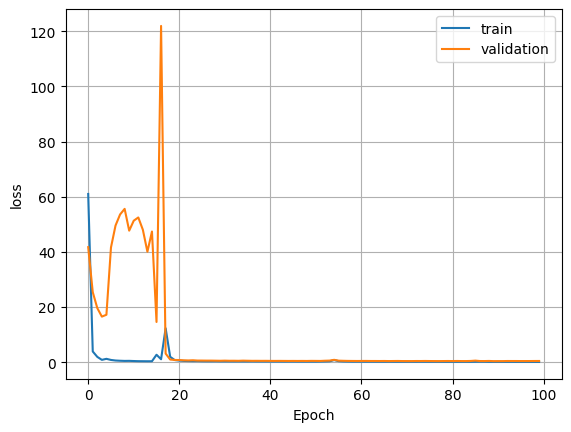

In [58]:
plot_loss(history)

#### **Early Stopping**

In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [60]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9744 - loss: 0.0863 - val_accuracy: 0.9232 - val_loss: 0.3820
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9736 - loss: 0.0787 - val_accuracy: 0.9299 - val_loss: 0.3904
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9718 - loss: 0.0827 - val_accuracy: 0.9232 - val_loss: 0.4275
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9779 - loss: 0.0752 - val_accuracy: 0.9182 - val_loss: 0.3929
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9705 - loss: 0.0824 - val_accuracy: 0.9215 - val_loss: 0.4048
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9742 - loss: 0.0738 - val_accuracy: 0.9232 - val_loss: 0.4032
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9772 - loss: 0.0681 - val_accuracy: 0.9316 - val_loss: 0.4245
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9831 - loss: 0.0521 - val_accuracy: 0.9249 - v

In [61]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9151 - loss: 1999.4685


{'accuracy': 0.9252336621284485, 'loss': 2397.44140625}

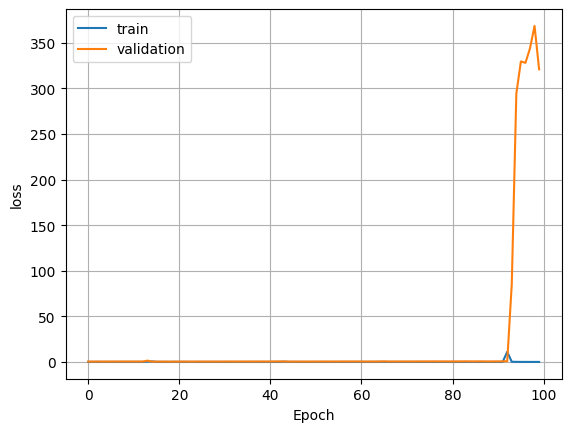

In [62]:
plot_loss(history)

In [63]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9151 - loss: 1999.4685


{'accuracy': 0.9252336621284485, 'loss': 2397.44140625}

---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END